# Step-by-step demonstration

## Lib Imports and configurations

In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

import sys
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from ruptures.metrics import precision_recall, meantime
import scipy.stats as ss
from itertools import islice

sys.path.append("Codes/")

import TMPD_utils
import TMPD_class

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
# pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
pd.options.display.float_format = '{:.4f}'.format


c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading event log

In [2]:
# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml.gz")

# Temp filter
logs_path = [x for x in logs_path if "_2" not in x and "_5" not in x and "Size1" in x and "Atomic" in x]

# Showing mapped paths
print("How many logs? ", len(logs_path))
pd.DataFrame(logs_path)

How many logs?  13


,0
0,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalMove\output\ConditionalMove.mxml.gz
1,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
2,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalToSequence\output\ConditionalToSequence.mxml.gz
3,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Frequency\output\Frequency.mxml.gz
4,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\Loop\output\Loop.mxml.gz
5,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelMove\output\ParallelMove.mxml.gz
6,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelRemoval\output\ParallelRemoval.mxml.gz
7,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ParallelToSequence\output\ParallelToSequence.mxml.gz
8,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialMove\output\SerialMove.mxml.gz
9,Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\SerialRemoval\output\SerialRemoval.mxml.gz


<!-- ![Alt text](../Images/Concept_drift_firstcycle_steps_eng.png "General steps") -->

In [3]:
# Loading first event log
log_path = logs_path[1]
print(log_path)
print(log_path.split("\\")[-5] + "/" + log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# This is a specifc step for this event log that remove an activity that shows where the drift happens
event_log = event_log[event_log['WorkflowModelElement'] != 'DRIFT_PO']

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# Showing loaded event log
print("Total events: ", len(event_log))
print("Total cases: ", len(event_log.groupby('CaseId')))
print("Total activities: ", len(event_log.groupby('Activity')))
event_log.head(30)

Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange\Size1\Atomic\ConditionalRemoval\output\ConditionalRemoval.mxml.gz
Size1/ConditionalRemoval
Total events:  61804
Total cases:  2999
Total activities:  27


,original_index,CaseId,Data,WorkflowModelElement,EventType,timestamp,Activity,Event_order_id
0,0,1,1970-01-01T10:33:47.462+10:00,a,complete,1970-01-01T10:33:47.462+10:00,a,0
1,1,1,1970-01-01T11:28:08.980+10:00,e,complete,1970-01-01T11:28:08.980+10:00,e,1
2,2,1,1970-01-01T11:32:51.926+10:00,d,complete,1970-01-01T11:32:51.926+10:00,d,2
3,3,1,1970-01-01T11:39:34.303+10:00,c,complete,1970-01-01T11:39:34.303+10:00,c,3
4,4,1,1970-01-01T12:32:42.811+10:00,i,complete,1970-01-01T12:32:42.811+10:00,i,4
5,5,1,1970-01-01T13:29:14.845+10:00,j,complete,1970-01-01T13:29:14.845+10:00,j,5
6,6,1,60,k,complete,1970-01-01T14:25:40.585+10:00,k,6
7,7,1,25,s,complete,1970-01-01T15:24:08.336+10:00,s,7
8,8,1,1970-01-01T15:24:10.079+10:00,m,complete,1970-01-01T15:24:10.079+10:00,m,8
9,9,1,1970-01-01T16:10:40.895+10:00,t,complete,1970-01-01T16:10:40.895+10:00,t,9


## Step 1 - Instantiating class and setting event log

In [4]:
# Iniatializing the TMPD_class
TMPD_instance = TMPD_class.TMPD(scenario='offline')

# Setting the transition log
TMPD_instance.set_transition_log(event_log, case_id='CaseId', activity_key='Activity', timestamp_key='timestamp', timestamp_format=None, other_columns_keys=[])

# Executing the transition log
TMPD_instance.run_transition_log()

# Showing the transition log created
print(len(TMPD_instance.get_transition_log()))
TMPD_instance.get_transition_log().head(30)

64803


,case_id,activity_from,timestamp_from,event_order_from,activity_to,timestamp_to,event_order_to,case_order,transition_id
0,1,START,1970-01-01T10:33:47.462+10:00,0,a,1970-01-01T10:33:47.462+10:00,0.0000,0,0
1,1,a,1970-01-01T10:33:47.462+10:00,0,e,1970-01-01T11:28:08.980+10:00,1.0000,1,1
2,1,e,1970-01-01T11:28:08.980+10:00,1,d,1970-01-01T11:32:51.926+10:00,2.0000,2,2
3,1,d,1970-01-01T11:32:51.926+10:00,2,c,1970-01-01T11:39:34.303+10:00,3.0000,3,3
4,1,c,1970-01-01T11:39:34.303+10:00,3,i,1970-01-01T12:32:42.811+10:00,4.0000,4,4
5,1,i,1970-01-01T12:32:42.811+10:00,4,j,1970-01-01T13:29:14.845+10:00,5.0000,5,5
6,1,j,1970-01-01T13:29:14.845+10:00,5,k,1970-01-01T14:25:40.585+10:00,6.0000,6,6
7,1,k,1970-01-01T14:25:40.585+10:00,6,s,1970-01-01T15:24:08.336+10:00,7.0000,7,7
8,1,s,1970-01-01T15:24:08.336+10:00,7,m,1970-01-01T15:24:10.079+10:00,8.0000,8,8
9,1,m,1970-01-01T15:24:10.079+10:00,8,t,1970-01-01T16:10:40.895+10:00,9.0000,9,9


## Step 2 - Setting Window Strategy

In [5]:
# Setting the window strategy parameters
TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 2000, continuous = True)
# TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 1, continuous = True)

# Executing the window strategy indexation
TMPD_instance.run_windowing_strategy()

# Showing the windows indexes
dict(list(TMPD_instance.get_windowing_strategy().items())[:15])

{0: {'start': 0, 'end': 8000, 'window_index': 0},
 1: {'start': 2000, 'end': 10000, 'window_index': 1},
 2: {'start': 4000, 'end': 12000, 'window_index': 2},
 3: {'start': 6000, 'end': 14000, 'window_index': 3},
 4: {'start': 8000, 'end': 16000, 'window_index': 4},
 5: {'start': 10000, 'end': 18000, 'window_index': 5},
 6: {'start': 12000, 'end': 20000, 'window_index': 6},
 7: {'start': 14000, 'end': 22000, 'window_index': 7},
 8: {'start': 16000, 'end': 24000, 'window_index': 8},
 9: {'start': 18000, 'end': 26000, 'window_index': 9},
 10: {'start': 20000, 'end': 28000, 'window_index': 10},
 11: {'start': 22000, 'end': 30000, 'window_index': 11},
 12: {'start': 24000, 'end': 32000, 'window_index': 12},
 13: {'start': 26000, 'end': 34000, 'window_index': 13},
 14: {'start': 28000, 'end': 36000, 'window_index': 14}}

## Step 3 - Setting Process Representation (using Transition Matrix)

In [6]:
# Setting the Transition Matrix (TM) process representation
TMPD_instance.set_process_representation(threshold_anomaly=0.0025
                                    , control_flow_features={'frequency', 'probability' } #, 'causality', 'parallel'
                                    , time_features={} 
                                    , resource_features={}
                                    , data_features={})

# Executing the process_representation using all dataset just for an example
TMPD_instance.run_process_representation(TMPD_instance.transition_log)

# Showing the process representation created
TMPD_instance.get_process_representation() #.head(15)

frequency  percentual  probability
activity_from activity_to                                    
START         a                 1515      0.0234       0.5052
              b                 1484      0.0229       0.4948
a             c                  512      0.0079       0.3380
              d                  491      0.0076       0.3241
              e                  512      0.0079       0.3380
b             f                  494      0.0076       0.3329
              g                  505      0.0078       0.3403
              h                  485      0.0075       0.3268
c             d                  509      0.0079       0.3360
              e                  493      0.0076       0.3254
              i                  513      0.0079       0.3386
d             c                  506      0.0078       0.3340
              e                  510      0.0079       0.3366
              i                  499      0.0077       0.3294
e             c                  497      0.0077       0.3281
              d                  515      0.0079       0.3399
              i                  503      0.0078       0.3320
f             g                  481      0.0074       0.3241
              h                  508      0.0078       0.3423
              i                  495      0.0076       0.3336
g             f                  506      0.0078       0.3410
              h                  491      0.0076       0.3309
              i                  487      0.0075       0.3282
h             f                  484      0.0075       0.3261
              g                  498      0.0077       0.3356
              i                  502      0.0077       0.3383
i             j                 2999      0.0463       1.0000
j             k                 4313      0.0666       1.0000
k             j                 1314      0.0203       0.3047
              l                  743      0.0115       0.1723
              m                  752      0.0116       0.1744
              s                 1504      0.0232       0.3487
l             r                  240      0.0037       0.1565
              s                  743      0.0115       0.4844
              t                  551      0.0085       0.3592
m             r                  208      0.0032       0.1420
              s                  752      0.0116       0.5133
              t                  505      0.0078       0.3447
n             o                 2999      0.0463       1.0000
o             p                 1489      0.0230       0.4965
              q                 1510      0.0233       0.5035
p             u                 1489      0.0230       1.0000
q             u                 1510      0.0233       1.0000
r             s                 1267      0.0196       1.0000
re            z                  988      0.0152       1.0000
s             l                  791      0.0122       0.1854
              m                  713      0.0110       0.1671
              r                  819      0.0126       0.1920
              t                 1943      0.0300       0.4555
t             n                 2999      0.0463       1.0000
u             v                 2240      0.0346       0.5206
              w                 2063      0.0318       0.4794
v             u                  685      0.0106       0.3058
              y                 1555      0.0240       0.6942
w             x                 2063      0.0318       1.0000
x             u                  619      0.0096       0.3000
              y                 1444      0.0223       0.7000
y             re                 988      0.0152       0.3294
              z                 2011      0.0310       0.6706
z             END               2999      0.0463       1.0000

## Step 4 - Setting Change Representation

In [7]:
# Defining the change features
change_features_strategy_dict = {
    'delta_matrix_strategy': 
        {
            'frequency_delta' : {'process_feature':'frequency', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'probability_delta' : {'process_feature':'probability', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'causality_delta' : {'process_feature':'causality', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'parallel_delta' : {'process_feature':'parallel', 'method':'aggregation', 'agg_function' : 'sum'}
            , 'frequency_delta_percentage' : {'process_feature':'frequency', 'method':'percentage'}
            , 'prob_freq_delta_weight' : {'process_feature':'probability', 'method':'aggregation_weight', 'agg_function' : 'sum', 'weight_feature' : 'frequency'}
            # , 'avg_time_delta' : {'process_feature':'avg_time', 'method':'aggregation', 'agg_function' : 'sum'}
            # , 'time_std_delta' : {'process_feature':'time_std', 'method':'aggregation', 'agg_function' : 'sum'}
        }
    , 'statistic_test_strategy' : 
        {
            'frequency_gtest_pvalue' : {'process_feature':'frequency', 'method':'g_test', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
            , 'frequency_cramersv' : {'process_feature':'frequency', 'method':'cramers_v', 'contingency_matrix_sum_value' : '5', 'remove_zeros':'True'}
        }
    }

# Setting Change Representation
TMPD_instance.set_change_representation(change_features_strategy_dict)

# Executing the Change Representation using the window strategy
TMPD_instance.run_change_representation()

# Showing the Change Representation created
TMPD_instance.get_change_representation().head(30)

,start,end,window_index,reference_window_index,frequency_delta,probability_delta,frequency_delta_percentage,prob_freq_delta_weight,frequency_gtest_pvalue,frequency_cramersv
0,0,8000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000,10000,1,0,254.0000,0.7854,0.0159,4.1894,1.0000,0.0000
2,4000,12000,2,0,228.0000,0.7273,0.0143,4.3208,1.0000,0.0000
3,6000,14000,3,0,330.0000,1.0487,0.0206,8.8768,1.0000,0.0000
4,8000,16000,4,0,542.0000,1.7494,0.0339,20.2416,0.9948,0.0000
5,10000,18000,5,0,628.0000,1.7740,0.0393,24.2915,0.8287,0.0000
6,12000,20000,6,0,578.0000,1.6594,0.0361,20.0583,0.9800,0.0000
7,14000,22000,7,0,780.0000,2.1244,0.0488,44.9907,0.0713,0.0316
8,16000,24000,8,0,950.0000,2.4329,0.0594,86.8567,0.0000,0.0789
9,18000,26000,9,0,1096.0000,2.6048,0.0685,141.3016,0.0000,0.1198


## Step 5 - Setting Detection Task

In [8]:
# Defining detection strategies
detection_task_strategy_dict = {
    'time_series_strategy': 
    {
        'cpd_frequency_delta' : {'change_features':['frequency_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cpd_prob_freq_delta' : {'change_features':['prob_freq_delta_weight'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_causality_delta' : {'change_features':['causality_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_prob_parallel_delta' : {'change_features':['parallel_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_avg_time_delta' : {'change_features':['avg_time_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        # , 'cpd_time_std_delta' : {'change_features':['time_std_delta'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'cpd_pelt', 'smooth' : '3'} #, 'model' : 'rbf', 'cost' : 'rpt.costs.CostRbf()', 'min_size' : '1', 'jump' : '1'
    }
    , 'threshold_strategy' : 
    {
        'gtest_frequency' : {'change_features':['frequency_gtest_pvalue'], 'method':'comparison_operator', 'operator' : 'le', 'threshold_value' : '0.025', 'smooth' : '3'}
        , 'cramersv_frequency' : {'change_features':['frequency_cramersv'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
        # , 'fixed_frequency_delta_percentage' : {'change_features':['frequency_delta_percentage'], 'method':'comparison_operator', 'operator' : 'ge', 'threshold_value' : '0.05', 'smooth' : '3'}
    }
}

# Setting Detection Task
TMPD_instance.set_detection_task(detection_task_strategy_dict)

# Executing the Detection Task
TMPD_instance.run_detection_task()

# Showing Detection Task Results
TMPD_instance.get_detection_task()


,detection_strategy,detection_feature,detection_results
0,time_series_strategy,cpd_frequency_delta,"[9, 20, 29]"
1,time_series_strategy,cpd_prob_freq_delta,"[10, 19, 29]"
2,time_series_strategy,cramersv_frequency,"[10, 19, 29]"
3,threshold_strategy,cramersv_frequency,"[8, 19, 29]"
4,threshold_strategy,gtest_frequency,"[8, 25, 29]"


In [9]:
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]

In [10]:
# Grounding truth
log_size = event_log['CaseId'].nunique()
ground_truth_traces_indexes = ["1000", "2000"]

transition_log = TMPD_instance.get_transition_log()
ground_truth_events_indexes = transition_log[transition_log['case_id'].isin(ground_truth_traces_indexes)].groupby('case_id').first()['transition_id'].to_list()
print(ground_truth_events_indexes)

# signals_indexes = signals.reset_index()
signals = TMPD_instance.get_change_representation()
ground_truth = []
for ground_truth_events_index in ground_truth_events_indexes:
    ground_truth.extend(signals[(signals['start'] <= ground_truth_events_index) 
                & (signals['end'] >= ground_truth_events_index)].head(1).index.to_list())
ground_truth = ground_truth + [len(signals)]
print("ground_truth: ", ground_truth)

[21822, 43105]
ground_truth:  [7, 18, 29]


In [11]:
### Validation metrics
margin_error_defined=3
detection_task_results = TMPD_instance.get_detection_task()
for index, row in detection_task_results.iterrows():
    try:
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)

        # smooth = int(detection_task_strategy_dict[row['detection_strategy']][row['detection_feature']]['smooth'])

        # Margin of error give more margin to overlap if used.
        margin_error = int(margin_error_defined + 1)  if TMPD_instance.overlap == False else int(margin_error_defined + 1 + TMPD_instance.window_size/TMPD_instance.sliding_step)

        precision, recall = precision_recall(ground_truth, row['detection_results'], margin=margin_error)

        f1 = round(ss.hmean([precision, recall]),2)
        detection_task_results.loc[index, 'f1'] = f1
        
        delay = round(meantime(ground_truth, row['detection_results']), 2)
        detection_task_results.loc[index, 'delay'] = delay

    except Exception as e:
        print("Error:", e)
        detection_task_results.loc[index, 'ground_truth'] = str(ground_truth)
        detection_task_results.loc[index, 'f1'] = np.nan
        detection_task_results.loc[index, 'delay'] = np.nan

detection_task_results

,detection_strategy,detection_feature,detection_results,ground_truth,f1,delay
0,time_series_strategy,cpd_frequency_delta,"[9, 20, 29]","[7, 18, 29]",1.0000,2.0000
1,time_series_strategy,cpd_prob_freq_delta,"[10, 19, 29]","[7, 18, 29]",1.0000,2.0000
2,time_series_strategy,cramersv_frequency,"[10, 19, 29]","[7, 18, 29]",1.0000,2.0000
3,threshold_strategy,cramersv_frequency,"[8, 19, 29]","[7, 18, 29]",1.0000,1.0000
4,threshold_strategy,gtest_frequency,"[8, 25, 29]","[7, 18, 29]",1.0000,4.0000


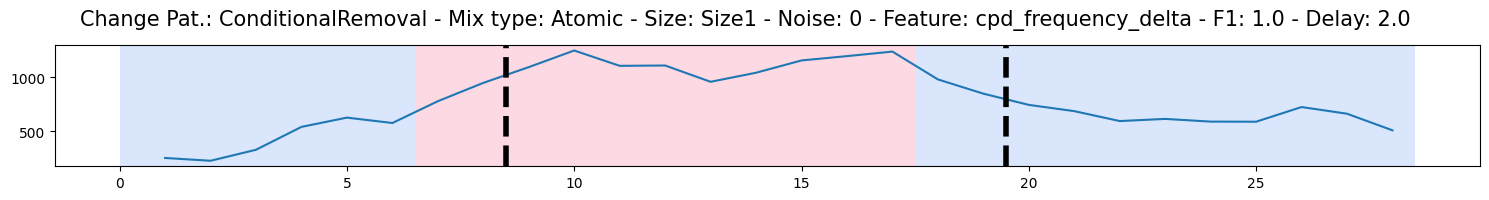

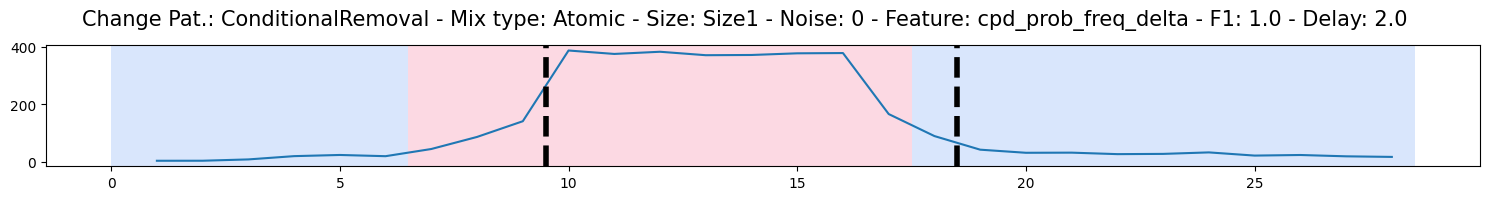

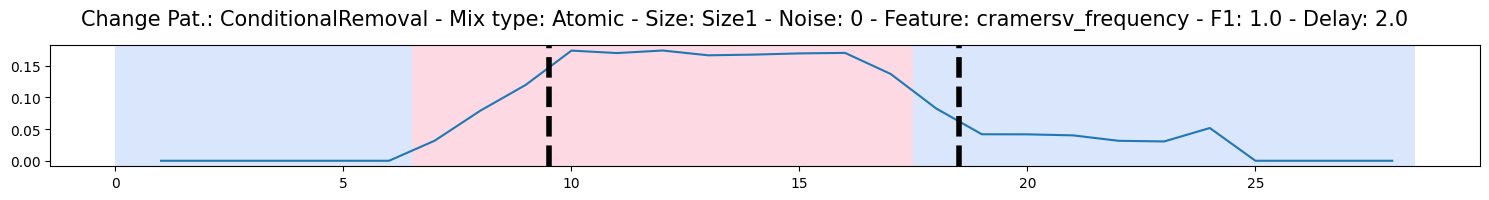

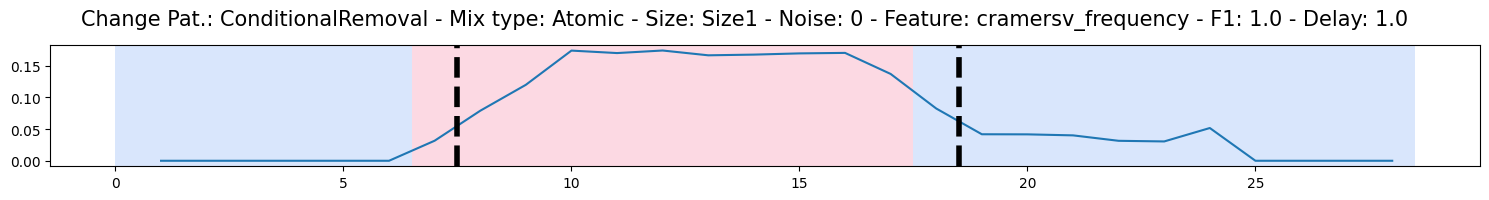

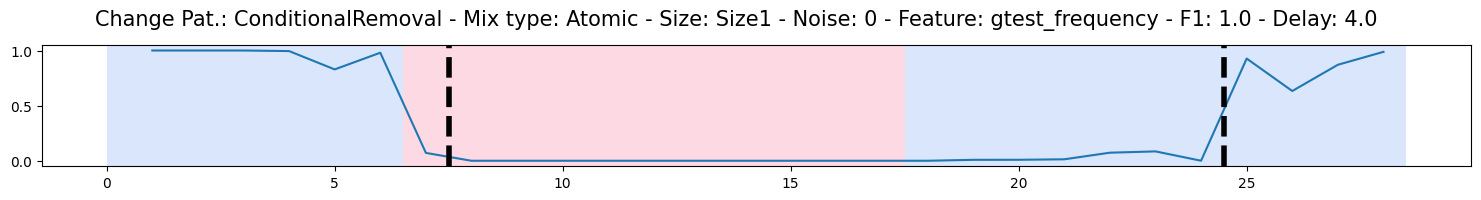

In [12]:
# Display Detection Task Results 
Noise = log_path.split("\\")[-1].split(".")[0].split("_")[-1] if log_path.split("\\")[-1].split(".")[0].split("_")[-1].isdigit() else 0

for result in detection_task_results.itertuples():
    fig, axarr = rpt.display(signal = TMPD_instance.get_change_representation()[TMPD_instance.detection_task_strategy_dict[result.detection_strategy][result.detection_feature]['change_features']]
                , true_chg_pts=ground_truth
                , computed_chg_pts = result.detection_results
                , computed_chg_pts_color = "k"
                , computed_chg_pts_linewidth = 4
                , computed_chg_pts_linestyle = "--"
                , computed_chg_pts_alpha = 1
                , figsize=(15, 2)
                )
    plt.suptitle("Change Pat.: " + str(log_path.split("\\")[-3])   
                 + " - Mix type: " + str(log_path.split("\\")[-4])  
                 + " - Size: " + str(log_path.split("\\")[-5]) 
                 + " - Noise: " + str(Noise)
                 + " - Feature: " + str(result.detection_feature) 
                 + " - F1: " + str(result.f1) 
                 + " - Delay: " + str(result.delay)
                 , fontsize=15)
    plt.subplots_adjust(top=0.8)
    plt.show()

## Step 6a - Setting Localization Task

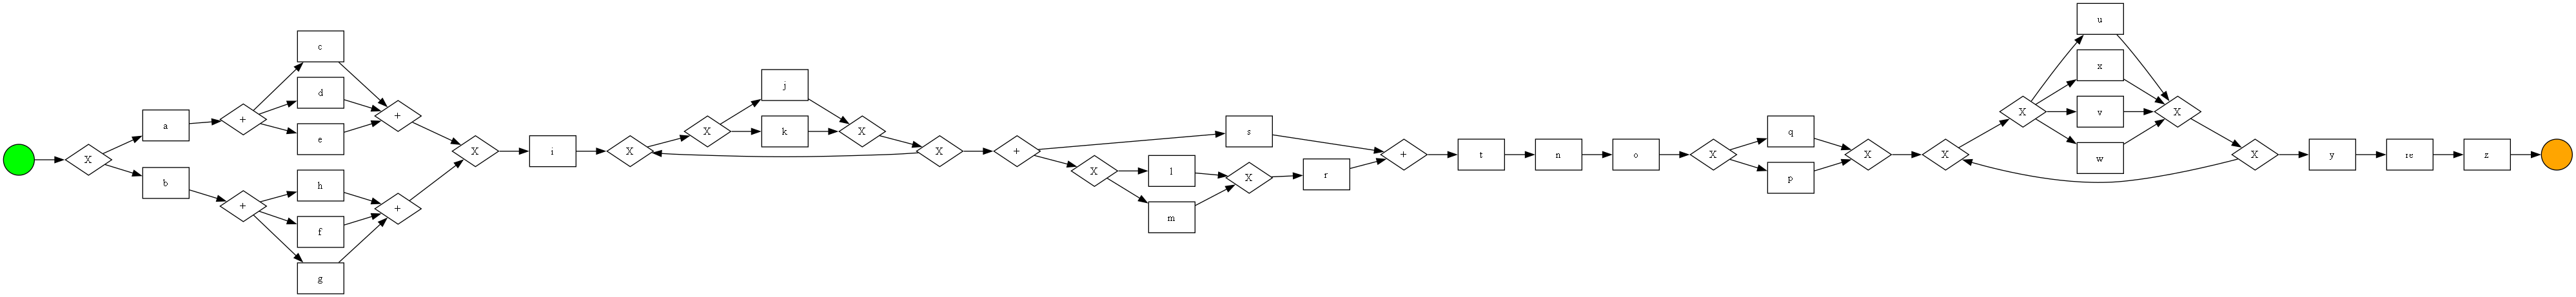

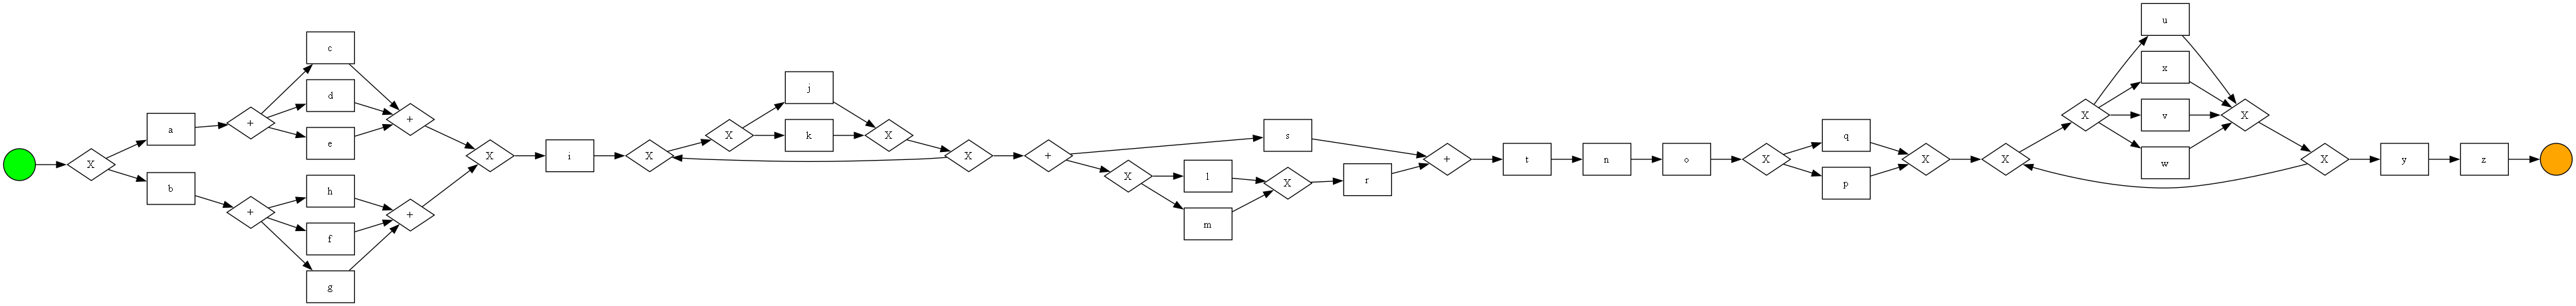

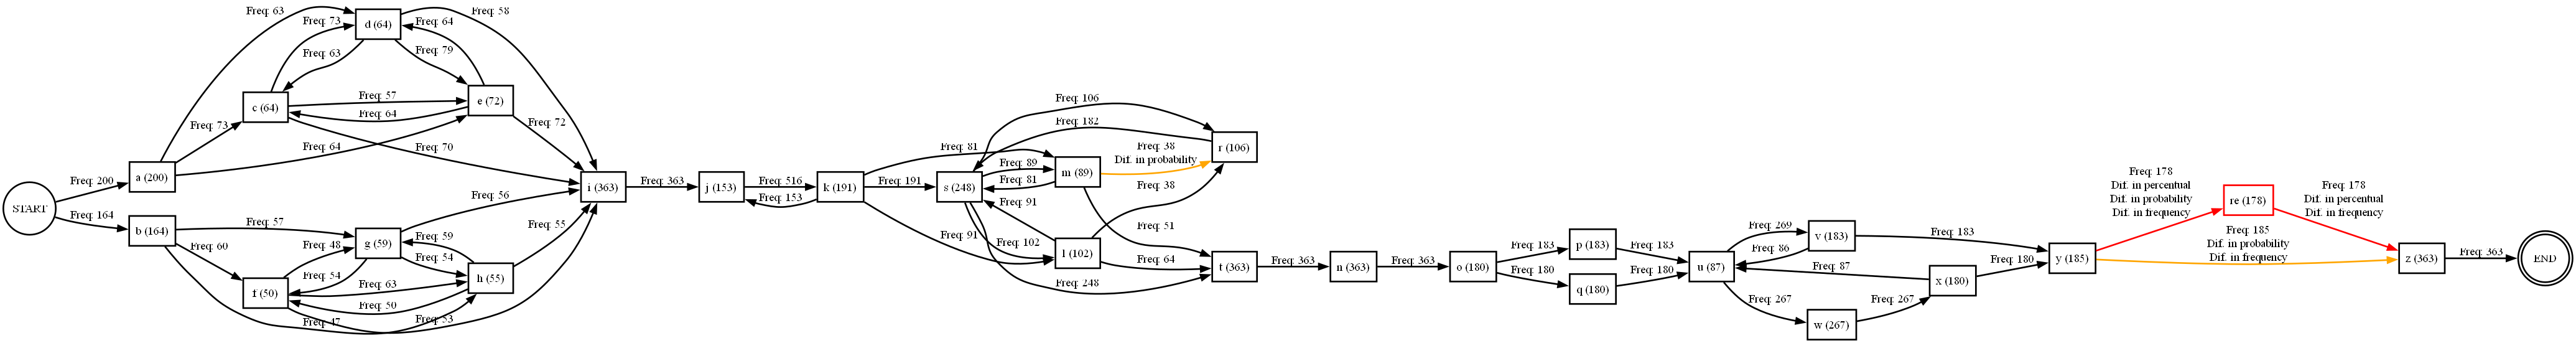

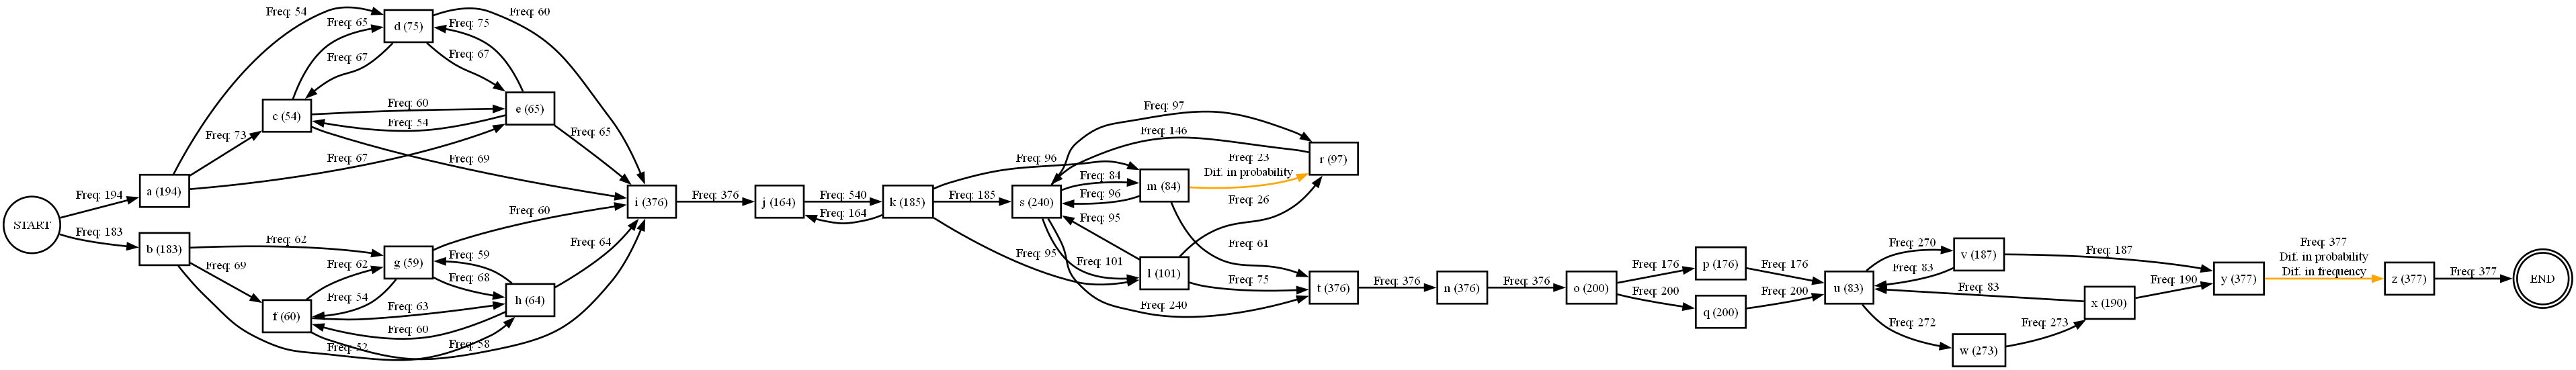

(  transition      feature  p_value  effect_size  ref_value  det_value  \
 0     (m, r)  probability   0.0245       0.2538     0.2235     0.1278   
 1    (re, z)   percentual   0.0000       0.2994     0.0222     0.0000   
 2    (re, z)    frequency   0.0000       0.1227   178.0000     0.0000   
 3    (y, re)   percentual   0.0451       0.2994     0.0222     0.0000   
 4    (y, re)  probability   0.0000       1.5515     0.4904     0.0000   
 5    (y, re)    frequency   0.0000       0.1227   178.0000     0.0000   
 6     (y, z)  probability   0.0000      -1.5515     0.5096     1.0000   
 7     (y, z)    frequency   0.0000       0.0650   185.0000   377.0000   
 
    dif_value  
 0    -0.0958  
 1    -0.0222  
 2  -178.0000  
 3    -0.0222  
 4    -0.4904  
 5  -178.0000  
 6     0.4904  
 7   192.0000  ,
 {'Transitions with variations in percentual': [('re', 'z'), ('y', 're')],
  'Transitions with variations in probability': [('m', 'r'),
   ('y', 're'),
   ('y', 'z')],
  'Transitions with

In [13]:
# Setting Localization Task
TMPD_instance.set_localization_task(reference_window_index=0, detection_window_index=14, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=5)

# Executing Localization Task
TMPD_instance.run_localization_task()

# Showing Localization Task Results
TMPD_instance.get_localization_task(show_localization_dfg=True, show_original_dfg=False, show_original_bpmn=True)

In [14]:
### Ground Truth
change_pattern_ground_truth = log_path.split("\\")[-3]

change_activities_ground_truth = {
    'ConditionalMove': {
        'change_pattern_name': 'Conditional-Move',
        'characterization_activities': ['n', 'p'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'ConditionalRemoval': {
        'change_pattern_name': 'Conditional-Switch',
        'characterization_activities': ['re'],
        'localization_activities': ['re', 'y', 'z']
    },
    'ConditionalToSequence': {
        'change_pattern_name': 'Conditional-To-Sequence',
        'characterization_activities': ['p', 'q'],
        'localization_activities': ['p', 'q', 'u', 'o']
    },
    'Frequency': {
        'change_pattern_name': 'Frequency',
        'characterization_activities': ['p', 'q', 'u', 'o'],
        'localization_activities': ['p', 'q', 'u', 'o']
    },
    'Loop': {
        'change_pattern_name': 'Loop',
        'characterization_activities': ['k'],
        'localization_activities': ['k', 'l', 's']
    },
    'ParallelMove': {
        'change_pattern_name': 'Parallel-Move',
        'characterization_activities': ['n', 'p'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'ParallelRemoval': {
        'change_pattern_name': 'Parallel-Switch',
        'characterization_activities': ['re'],
        'localization_activities': ['y', 'z', 'z1']
    },
    'ParallelToSequence': {
        'change_pattern_name': 'Parallel-To-Sequence',
        'characterization_activities': ['n', 'o'],
        'localization_activities': ['n', 'o', 't', 'p']
    },
    'SerialMove': {
        'change_pattern_name': 'Serial-Move',
        'characterization_activities': ['n'],
        'localization_activities': ['n', 'p', 't', 'o', 'u']
    },
    'SerialRemoval': {
        'change_pattern_name': 'Serial-Switch',
        'characterization_activities': ['re'],
        'localization_activities': ['re', 'y', 'z']
    },
    'Skip': {
        'change_pattern_name': 'Skip',
        'characterization_activities': ['n'],
        'localization_activities': ['n', 't', 'o']
    },
    'Substitute': {
        'change_pattern_name': 'Replace',
        'characterization_activities': ['sub', 'z1'],
        'localization_activities': ['sub', 'z1', 'z', 'y']
    },
    'Swap': {
        'change_pattern_name': 'Swap',
        'characterization_activities': ['n', 'o'],
        'localization_activities': ['n', 'o', 't', 'p', 'u']
    } 
}

localization_ground_truth = change_activities_ground_truth[change_pattern_ground_truth]['localization_activities']
localization_ground_truth

['re', 'y', 'z']

In [15]:
### Validation metrics

# Getting the distinct activities in the Localization Result
localization_distinct_activities = set()
for key, value in islice(TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1].items(), 6):
    if isinstance(value, list): # Check if the value is a list
        # Skip the list if it contains only "None"
        if len(value) == 1 and value[0] == "None":
            continue
        for item in value:
            if isinstance(item, tuple): # If the items are tuples, extend the set with the tuple items
                localization_distinct_activities.update(item)
            else: # If the items are not tuples (i.e., strings), add them directly to the set
                localization_distinct_activities.add(item)
localization_result = list(localization_distinct_activities)
print(localization_result)

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(localization_ground_truth, localization_result)

localization_task_validation_results = ({
    'localization_activities_precision': precision,
    'localization_activities_recall': recall,
    'localization_activities_f1_score': f1_score
})

localization_task_validation_results

['z', 'm', 'r', 're', 'y']


{'localization_activities_precision': 0.6,
 'localization_activities_recall': 1.0,
 'localization_activities_f1_score': 0.7499999999999999}

In [16]:
# # Skip Pattern temporary test
# TMPD_instance.detection_bpmn_text = "Sequence( Conditional( Sequence( 'b', Parallel( 'h', 'f', 'g' ) ), Sequence( 'a', Parallel( 'e', 'd', 'c' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Parallel( 'm', 'l' ), 'r' ) ), 't', Conditional( 'n', 'tau'), 'o', 'p', Loop( Conditional( 'x', 'v', 'w', 'u' ), tau ), 'y', 'z' )"
# TMPD_instance.detection_bpmn_text

# # Conditional Removal Pattern temporary test
# TMPD_instance.reference_bpmn_text = "Sequence( Conditional( Sequence( 'b', Parallel( 'h', 'f', 'g' ) ), Sequence( 'a', Parallel( 'c', 'd', 'e' ) ) ), 'i', Loop( Conditional( 'j', 'k' ), tau ), Parallel( 's', Sequence( Conditional( 'm', 'l' ), 'r' ) ), 't', 'n', 'o', Conditional( 'p', 'q' ), Loop( Conditional( 'w', 'u', 'x', 'v' ), tau ), 'y', Conditional( 're', 'z') )"
# TMPD_instance.reference_bpmn_text

## Step 6b - Setting Characterization Task

In [17]:
# Setting Characterization Task
# TMPD_instance.set_characterization_task(llm_company = "openai", llm_model="gpt-4o", api_key_path='Temp/openai_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v0.yaml') # "gpt-4o", "gpt-3.5-turbo-0125", "gpt-4"
TMPD_instance.set_characterization_task(llm_company = "google", llm_model="gemini-2.0-flash", api_key_path='Temp/google_api_key.txt', llm_instructions_path='Codes/LLM_Instructions/instructions_v0.yaml')

# Executing Characterization Task
TMPD_instance.run_characterization_task()

# Showing Characterization Task Results
TMPD_instance.get_characterization_task()

################################ llm_bpmn_analysis_prompt #####################################
### Introduction ###
You are a technical analyst specializing in concept drift in process mining. 
Your primary role is to investigate the phenomenon of concept drift by comparing two distinct phases of a business process: the reference window (before the change) and the detection window (after the change).


### BPMN Diagrams Comparison ###
You will be provided with detailed BPMN diagrams for both time frame (reference and detection windows).

Familiarize yourself with the BPMN symbols used in the diagrams:
    - Control-flow operators:
        - Sequence fragments are denoted by 'Sequence'. Each item in a sequence fragment will be executed in order.
        - Parallel fragments by 'Parallel'. Each item in a parallel fragment will be executed, but not necessarily in order.
        - Conditional fragments by 'Conditional'. Only one item in a conditional fragment will be executed.
        - L

({'concept_drift': ['Yes'],
  'change_pattern': ['Serial-Switch'],
  'activities': ['re']},
 "Based on the provided analysis, a concept drift has occurred. The most significant change pattern is Serial-Switch, due to the deletion of activity 're' which was located in a Sequence fragment between activities 'y' and 'z'.\n\n### result_dict = {'concept_drift' : ['Yes'], 'change_pattern' : ['Serial-Switch'], 'activities' : ['re']}\n",
 "### BPMN diagrams Comparison Analysis: ###\n\n*   **Addition or removal of activities:**\n    *   Activity 're' was deleted from the detection window. It was after activity 'y' and before activity 'z' in the outermost Sequence fragment.\n*   **Addition or removal of control-flow operators:**\n    *   No control-flow operators were added or removed.\n*   **Movements of items within Sequence fragments:**\n    *   No activity was moved.\n    *   Check swap: No activity was swapped.\n*   **Addition or removal of silent transitions:**\n    *   No silent transitio

In [18]:
### Ground Truth

characterization_ground_truth = {'concept_drift' : ['Yes'], 'change_pattern' : [change_activities_ground_truth[change_pattern_ground_truth]['change_pattern_name']], 'activities' : change_activities_ground_truth[change_pattern_ground_truth]['characterization_activities']}
characterization_ground_truth

{'concept_drift': ['Yes'],
 'change_pattern': ['Conditional-Switch'],
 'activities': ['re']}

In [19]:
### Validation metrics

characterization_result = TMPD_instance.get_characterization_task()[0]

# Initialize a results dictionary
characterization_task_validation_results = {
    'characterization_concept_drift_match': None,
    'characterization_change_pattern_match_f1_score': None,
    'characterization_change_pattern_match_precision': None,
    'characterization_change_pattern_match_recall': None,
    'characterization_activities_precision': None,
    'characterization_activities_recall': None,
    'characterization_activities_f1_score': None
}

# Check matches
try:
    characterization_task_validation_results['characterization_concept_drift_match'] = TMPD_utils.list_match_metrics(characterization_ground_truth['concept_drift'], characterization_result['concept_drift'])[2]
except:
    characterization_task_validation_results['characterization_concept_drift_match'] = -1

try:
    precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['change_pattern'], characterization_result['change_pattern'])
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': f1_score,
        'characterization_change_pattern_match_precision': precision,
        'characterization_change_pattern_match_recall': recall
    })

except:
    characterization_task_validation_results.update({
        'characterization_change_pattern_match_f1_score': -1,
        'characterization_change_pattern_match_precision': -1,
        'characterization_change_pattern_match_recall': -1
    })

# Set comparison for 'Activities'
precision, recall, f1_score = TMPD_utils.list_match_metrics(characterization_ground_truth['activities'], characterization_result['activities'])

characterization_task_validation_results.update({
    'characterization_activities_precision': precision,
    'characterization_activities_recall': recall,
    'characterization_activities_f1_score': f1_score
})

characterization_task_validation_results


{'characterization_concept_drift_match': 1.0,
 'characterization_change_pattern_match_f1_score': 0,
 'characterization_change_pattern_match_precision': 0.0,
 'characterization_change_pattern_match_recall': 0.0,
 'characterization_activities_precision': 1.0,
 'characterization_activities_recall': 1.0,
 'characterization_activities_f1_score': 1.0}

In [20]:
understanding_tasks_results = pd.DataFrame([{**characterization_task_validation_results}])
understanding_tasks_results['localization_activities'] = ', '.join(localization_result) 
understanding_tasks_results['characterization_change_pattern'] = ', '.join(TMPD_instance.get_characterization_task()[0]['change_pattern']) 
understanding_tasks_results['characterization_activities'] = ', '.join(TMPD_instance.get_characterization_task()[0]['activities']) 
understanding_tasks_results['localization_changes'] = [TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[1]]
understanding_tasks_results['reference_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[2]
understanding_tasks_results['detection_bpmn_text'] = TMPD_instance.get_localization_task(show_localization_dfg=False, show_original_dfg=False, show_original_bpmn=False)[3]
understanding_tasks_results['change_patterns_llm_response'] = TMPD_instance.get_characterization_task()[1]
understanding_tasks_results

,characterization_concept_drift_match,characterization_change_pattern_match_f1_score,characterization_change_pattern_match_precision,characterization_change_pattern_match_recall,characterization_activities_precision,characterization_activities_recall,characterization_activities_f1_score,localization_activities,characterization_change_pattern,characterization_activities,localization_changes,reference_bpmn_text,detection_bpmn_text,change_patterns_llm_response
0,1.0000,0,0.0000,0.0000,1.0000,1.0000,1.0000,"z, m, r, re, y",Serial-Switch,re,"{'Transitions with variations in percentual': [('re', 'z'), ('y', 're')], 'Transitions with variations in probability': [('m', 'r'), ('y', 're'), ...","Sequence( Conditional( Sequence( 'a', Parallel( 'c', 'd', 'e' ) ), Sequence( 'b', Parallel( 'h', 'f', 'g' ) ) ), 'i', Loop( Conditional( 'j', 'k' ...","Sequence( Conditional( Sequence( 'a', Parallel( 'c', 'd', 'e' ) ), Sequence( 'b', Parallel( 'h', 'f', 'g' ) ) ), 'i', Loop( Conditional( 'j', 'k' ...","Based on the provided analysis, a concept drift has occurred. The most significant change pattern is Serial-Switch, due to the deletion of activit..."


## Step 6c - Setting Explanation Task

In [21]:
# TODO